# Pokemon Sprite Generation: Data Pipeline

Streamlined data preparation for artwork-to-sprite translation model. This notebook handles:

1. **Dataset acquisition** - Download paired Sugimori artwork and B/W sprites
2. **Data verification** - Visual inspection of artwork-sprite pairs  
3. **Preprocessing pipeline** - Multi-scale preparation optimized for pixel art generation

Based on established image-to-image translation methodologies (Isola et al., 2017) with pixel art specific optimizations.

In [20]:
import sys
import json
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import random
from tqdm import tqdm

# Project paths
src_path = Path("../src")
data_dir = Path("../data")
sys.path.insert(0, str(src_path))

print("Environment ready")

Environment ready


In [21]:
def download_pokemon_dataset():
    """Download Pokemon artwork and sprites with efficient caching"""
    
    dataset_dir = data_dir / "pokemon_complete"
    artwork_dir = dataset_dir / "artwork"
    sprites_dir = dataset_dir / "sprites"
    
    # Create directories
    for dir_path in [dataset_dir, artwork_dir, sprites_dir]:
        dir_path.mkdir(exist_ok=True)
    
    # Check existing data
    existing_artwork = len(list(artwork_dir.glob("*.png")))
    existing_sprites = len(list(sprites_dir.glob("*.png")))
    
    print(f"Current dataset: {existing_artwork} artwork, {existing_sprites} sprites")
    
    if existing_artwork > 800 and existing_sprites > 800:
        print("Dataset complete, skipping download")
        return dataset_dir
    
    print("Downloading missing Pokemon data...")
    
    # Download range (covers all major generations)
    pokemon_range = range(1, 1026)
    downloaded = 0
    
    for pokemon_id in tqdm(pokemon_range, desc="Downloading"):
        # Artwork (Sugimori official art)
        artwork_path = artwork_dir / f"{pokemon_id:04d}.png"
        if not artwork_path.exists():
            artwork_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/{pokemon_id}.png"
            try:
                response = requests.get(artwork_url, timeout=5)
                if response.status_code == 200:
                    artwork_path.write_bytes(response.content)
                    downloaded += 1
            except:
                continue
        
        # B/W Sprite
        sprite_path = sprites_dir / f"{pokemon_id:04d}.png"
        if not sprite_path.exists():
            sprite_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/versions/generation-v/black-white/{pokemon_id}.png"
            try:
                response = requests.get(sprite_url, timeout=5)
                if response.status_code == 200:
                    sprite_path.write_bytes(response.content)
                    downloaded += 1
            except:
                continue
    
    print(f"Download complete. {downloaded} new files acquired")
    return dataset_dir

# Execute download
dataset_dir = download_pokemon_dataset()

Current dataset: 1025 artwork, 898 sprites
Dataset complete, skipping download


Found 898 valid artwork-sprite pairs


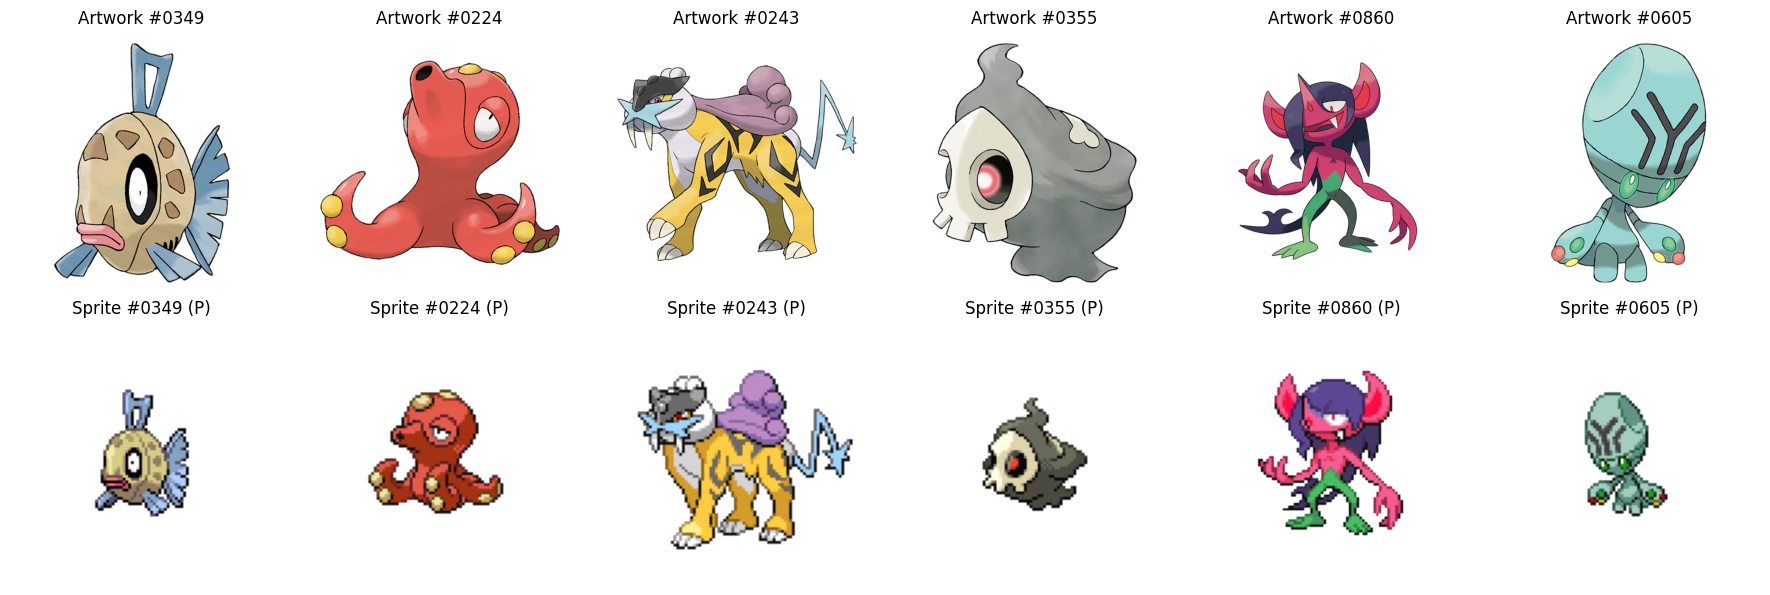

Sprite format: P (1 channels)


In [22]:
def verify_dataset_pairs(dataset_dir, num_samples=6):
    """Verify artwork-sprite pairs with visual inspection"""
    
    artwork_dir = dataset_dir / "artwork"
    sprites_dir = dataset_dir / "sprites"
    
    # Find valid pairs
    artwork_files = {f.stem: f for f in artwork_dir.glob("*.png")}
    sprite_files = {f.stem: f for f in sprites_dir.glob("*.png")}
    
    valid_pairs = []
    for pokemon_id in artwork_files:
        if pokemon_id in sprite_files:
            # Check file validity
            try:
                artwork_img = Image.open(artwork_files[pokemon_id])
                sprite_img = Image.open(sprite_files[pokemon_id])
                if artwork_img.size[0] > 100 and sprite_img.size[0] > 30:  # Basic size check
                    valid_pairs.append((artwork_files[pokemon_id], sprite_files[pokemon_id]))
            except:
                continue
    
    print(f"Found {len(valid_pairs)} valid artwork-sprite pairs")
    
    # Visual verification
    sample_pairs = random.sample(valid_pairs, min(num_samples, len(valid_pairs)))
    
    fig, axes = plt.subplots(2, len(sample_pairs), figsize=(3*len(sample_pairs), 6))
    if len(sample_pairs) == 1:
        axes = axes.reshape(2, 1)
    
    for i, (artwork_path, sprite_path) in enumerate(sample_pairs):
        # Load images
        artwork = Image.open(artwork_path)
        sprite = Image.open(sprite_path)  # Keep original format (likely RGBA)
        
        # Display artwork
        axes[0, i].imshow(artwork)
        axes[0, i].set_title(f"Artwork #{artwork_path.stem}")
        axes[0, i].axis('off')
        
        # Display sprite with proper transparency handling
        if sprite.mode == 'RGBA':
            # Display RGBA sprite with matplotlib's alpha support
            sprite_array = np.array(sprite)
            axes[1, i].imshow(sprite_array)
            axes[1, i].set_title(f"Sprite #{sprite_path.stem} (RGBA)")
        else:
            # Fallback for non-RGBA sprites
            axes[1, i].imshow(sprite)
            axes[1, i].set_title(f"Sprite #{sprite_path.stem} ({sprite.mode})")
        
        axes[1, i].axis('off')
        
        # Set transparent background for sprite subplot
        axes[1, i].set_facecolor('none')
    
    plt.tight_layout()
    plt.show()
    
    # Print channel information
    sample_sprite = Image.open(sample_pairs[0][1])
    print(f"Sprite format: {sample_sprite.mode} ({len(sample_sprite.getbands())} channels)")
    if sample_sprite.mode == 'RGBA':
        print("RGBA format preserved - transparency channels available for training")
    
    return len(valid_pairs)

# Verify dataset
total_pairs = verify_dataset_pairs(dataset_dir)

In [23]:
def create_preprocessing_pipeline(dataset_dir):
    """
    Preprocessing pipeline optimized for artwork-to-sprite translation.
    
    Processes inputs (artwork) at multiple scales while keeping outputs (sprites) 
    at consistent 256px resolution with proper channel preservation.
    Uses intelligent caching to skip preprocessing if data already exists.
    """
    
    artwork_dir = dataset_dir / "artwork"
    sprites_dir = dataset_dir / "sprites"
    processed_dir = dataset_dir / "processed"
    
    # Check if preprocessing cache exists and is complete
    metadata_path = processed_dir / "metadata.json"
    if metadata_path.exists():
        print("Found existing preprocessing cache, checking completeness...")
        
        try:
            with open(metadata_path, 'r') as f:
                existing_metadata = json.load(f)
            
            # Verify cache completeness
            input_scales = existing_metadata.get('input_scales', [128, 192, 256])
            cache_complete = True
            
            for scale in input_scales:
                scale_dir = processed_dir / f"input_{scale}"
                artwork_cache = scale_dir / "artwork"
                sprite_cache = scale_dir / "sprites"
                
                if not (artwork_cache.exists() and sprite_cache.exists()):
                    cache_complete = False
                    break
                
                # Check if cache has reasonable amount of data
                artwork_count = len(list(artwork_cache.glob("*.png")))
                sprite_count = len(list(sprite_cache.glob("*.png")))
                
                if artwork_count < 50 or sprite_count < 50:  # Minimum threshold
                    cache_complete = False
                    break
            
            if cache_complete:
                print(f"Cache complete with {existing_metadata.get('total_pairs', 0)} processed pairs")
                print("Skipping preprocessing - using cached data")
                return processed_dir, existing_metadata
            else:
                print("Cache incomplete, proceeding with preprocessing...")
                
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Cache metadata corrupted ({e}), regenerating...")
    
    # Create output directories - only input scaling, outputs stay at 256px
    input_scales = [128, 192, 256]  # Progressive input sizes for curriculum learning
    scale_dirs = {}
    
    for scale in input_scales:
        scale_dir = processed_dir / f"input_{scale}"
        scale_dir.mkdir(parents=True, exist_ok=True)
        (scale_dir / "artwork").mkdir(exist_ok=True)
        (scale_dir / "sprites").mkdir(exist_ok=True)
        scale_dirs[scale] = scale_dir
    
    # Find valid pairs
    artwork_files = list(artwork_dir.glob("*.png"))
    sprite_files = list(sprites_dir.glob("*.png"))
    
    artwork_ids = {f.stem for f in artwork_files}
    sprite_ids = {f.stem for f in sprite_files}
    valid_ids = artwork_ids & sprite_ids
    
    print(f"Processing {len(valid_ids)} valid pairs with input scales: {input_scales}")
    print("Preserving original channel formats for both artwork and sprites")
    
    processed_count = 0
    failed_count = 0
    skipped_count = 0
    artwork_modes = set()
    sprite_modes = set()
    
    for pokemon_id in tqdm(valid_ids, desc="Preprocessing"):
        try:
            # Check if this Pokemon is already processed in all scales
            all_scales_exist = True
            for input_scale in input_scales:
                artwork_out = scale_dirs[input_scale] / "artwork" / f"{pokemon_id}.png"
                sprite_out = scale_dirs[input_scale] / "sprites" / f"{pokemon_id}.png"
                
                if not (artwork_out.exists() and sprite_out.exists()):
                    all_scales_exist = False
                    break
            
            if all_scales_exist:
                skipped_count += 1
                # Still need to track formats for metadata
                artwork_path = artwork_dir / f"{pokemon_id}.png"
                sprite_path = sprites_dir / f"{pokemon_id}.png"
                if artwork_path.exists() and sprite_path.exists():
                    artwork = Image.open(artwork_path)
                    sprite = Image.open(sprite_path)
                    artwork_modes.add(artwork.mode)
                    sprite_modes.add(sprite.mode)
                continue
            
            # Load original images
            artwork_path = artwork_dir / f"{pokemon_id}.png"
            sprite_path = sprites_dir / f"{pokemon_id}.png"
            
            artwork = Image.open(artwork_path)  # Keep original mode
            sprite = Image.open(sprite_path)    # Keep original mode
            
            # Track original formats
            artwork_modes.add(artwork.mode)
            sprite_modes.add(sprite.mode)
            
            # Ensure RGBA for both if they have transparency, otherwise keep original
            if artwork.mode in ['RGBA', 'LA'] or 'transparency' in artwork.info:
                artwork_final = artwork.convert('RGBA')
            else:
                artwork_final = artwork.convert('RGB')
            
            if sprite.mode in ['RGBA', 'LA'] or 'transparency' in sprite.info:
                sprite_final = sprite.convert('RGBA')
            else:
                sprite_final = sprite.convert('RGB')
            
            # Process artwork at different input scales, sprites always 256px
            for input_scale in input_scales:
                artwork_out = scale_dirs[input_scale] / "artwork" / f"{pokemon_id}.png"
                sprite_out = scale_dirs[input_scale] / "sprites" / f"{pokemon_id}.png"
                
                # Skip if this specific scale already exists
                if artwork_out.exists() and sprite_out.exists():
                    continue
                
                # Artwork preprocessing - scale input
                artwork_resized = artwork_final.resize((input_scale, input_scale), Image.Resampling.LANCZOS)
                
                # Sprite preprocessing - always 256px, preserve format
                sprite_256 = sprite_final.resize((256, 256), Image.Resampling.NEAREST)
                
                # Apply minimal pixel art enhancement
                if sprite_final.mode == 'RGBA':
                    # Posterize RGB channels only, keep alpha intact
                    rgb_channels = sprite_256.split()[:3]  # R, G, B
                    alpha_channel = sprite_256.split()[3]   # A
                    posterized_rgb = [ImageOps.posterize(channel, bits=6) for channel in rgb_channels]
                    sprite_enhanced = Image.merge('RGBA', posterized_rgb + [alpha_channel])
                else:
                    # RGB only
                    sprite_enhanced = ImageOps.posterize(sprite_256, bits=6)
                
                # Save processed images
                artwork_resized.save(artwork_out, 'PNG')
                sprite_enhanced.save(sprite_out, 'PNG')
            
            processed_count += 1
            
        except Exception as e:
            failed_count += 1
            continue
    
    total_processed = processed_count + skipped_count
    
    print(f"Preprocessing complete: {processed_count} pairs processed, {skipped_count} pairs cached, {failed_count} failed")
    print(f"Detected artwork formats: {artwork_modes}")
    print(f"Detected sprite formats: {sprite_modes}")
    
    # Generate dataset statistics
    stats = {}
    for scale in input_scales:
        artwork_count = len(list((scale_dirs[scale] / "artwork").glob("*.png")))
        sprite_count = len(list((scale_dirs[scale] / "sprites").glob("*.png")))
        stats[f"input_{scale}"] = {"artwork": artwork_count, "sprites": sprite_count}
    
    # Save preprocessing metadata
    metadata = {
        "input_scales": input_scales,
        "output_resolution": 256,
        "original_artwork_formats": list(artwork_modes),
        "original_sprite_formats": list(sprite_modes),
        "total_pairs": total_processed,
        "processed_pairs": processed_count,
        "cached_pairs": skipped_count,
        "failed_pairs": failed_count,
        "preprocessing_method": "multi_scale_input_fixed_output",
        "sprite_enhancement": "posterization_6bit_format_preserved",
        "artwork_resampling": "lanczos",
        "sprite_resampling": "nearest_neighbor",
        "stats": stats
    }
    
    with open(processed_dir / "metadata.json", 'w') as f:
        json.dump(metadata, f, indent=2)
    
    return processed_dir, metadata

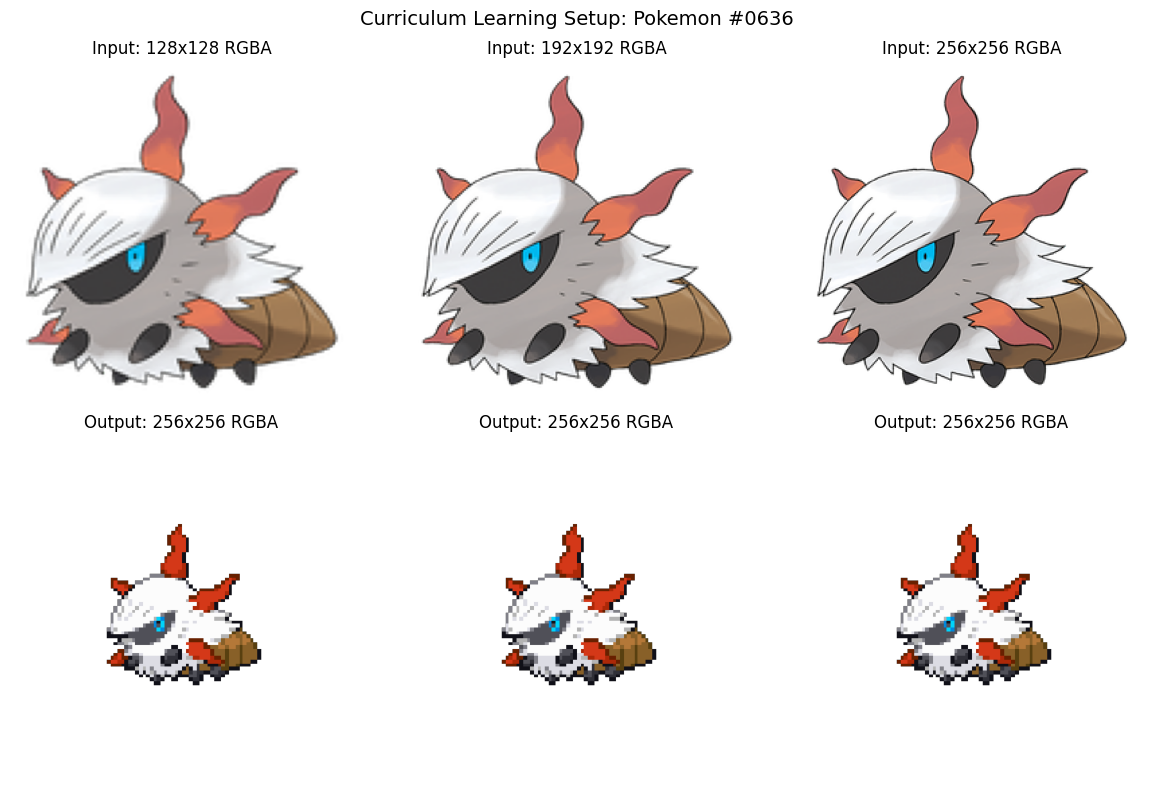


Preprocessing Summary:
├── Method: multi_scale_input_fixed_output
├── Input scales: [128, 192, 256]
├── Output resolution: 256px
├── Original artwork formats: ['RGBA']
├── Original sprite formats: ['RGBA', 'P']
├── Total pairs: 898
├── Failed pairs: 0
└── Success rate: 100.0%

DATA PIPELINE COMPLETE

Ready for curriculum learning with input scaling:
1. Start training: 128px artwork → 256px sprite
2. Continue training: 192px artwork → 256px sprite
3. Final training: 256px artwork → 256px sprite

This approach reduces overfitting by progressively increasing
input complexity while maintaining consistent output quality.
\nOriginal formats preserved: Artwork ['RGBA'], Sprites ['RGBA', 'P']


In [24]:
def verify_preprocessing(processed_dir, metadata):
    """Verify preprocessing results with sample visualization"""
    
    input_scales = metadata['input_scales']
    
    # Sample a random Pokemon for verification
    first_scale_dir = processed_dir / f"input_{input_scales[0]}"
    sample_files = list((first_scale_dir / "artwork").glob("*.png"))
    if not sample_files:
        print("No processed files found")
        return
    
    sample_id = random.choice(sample_files).stem
    
    fig, axes = plt.subplots(2, len(input_scales), figsize=(4*len(input_scales), 8))
    
    for i, input_scale in enumerate(input_scales):
        scale_dir = processed_dir / f"input_{input_scale}"
        
        # Load processed images
        artwork_path = scale_dir / "artwork" / f"{sample_id}.png"
        sprite_path = scale_dir / "sprites" / f"{sample_id}.png"
        
        if artwork_path.exists() and sprite_path.exists():
            artwork = Image.open(artwork_path)
            sprite = Image.open(sprite_path)
            
            # Display artwork with transparency support
            if artwork.mode == 'RGBA':
                artwork_array = np.array(artwork)
                axes[0, i].imshow(artwork_array)
                axes[0, i].set_title(f"Input: {input_scale}x{input_scale} RGBA")
            else:
                axes[0, i].imshow(artwork)
                axes[0, i].set_title(f"Input: {input_scale}x{input_scale} RGB")
            axes[0, i].axis('off')
            
            # Display sprite with transparency
            if sprite.mode == 'RGBA':
                sprite_array = np.array(sprite)
                axes[1, i].imshow(sprite_array)
                axes[1, i].set_title(f"Output: 256x256 RGBA")
            else:
                axes[1, i].imshow(sprite)
                axes[1, i].set_title(f"Output: 256x256 RGB")
            
            axes[1, i].axis('off')
            axes[1, i].set_facecolor('none')
    
    plt.suptitle(f"Curriculum Learning Setup: Pokemon #{sample_id}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nPreprocessing Summary:")
    print(f"├── Method: {metadata['preprocessing_method']}")
    print(f"├── Input scales: {metadata['input_scales']}")
    print(f"├── Output resolution: {metadata['output_resolution']}px")
    print(f"├── Original artwork formats: {metadata['original_artwork_formats']}")
    print(f"├── Original sprite formats: {metadata['original_sprite_formats']}")
    print(f"├── Total pairs: {metadata['total_pairs']}")
    print(f"├── Failed pairs: {metadata['failed_pairs']}")
    print(f"└── Success rate: {(metadata['total_pairs'] / (metadata['total_pairs'] + metadata['failed_pairs']) * 100):.1f}%")

# Verify preprocessing results
verify_preprocessing(processed_dir, metadata)

print("\n" + "="*60)
print("DATA PIPELINE COMPLETE")
print("="*60)
print("\nReady for curriculum learning with input scaling:")
print("1. Start training: 128px artwork → 256px sprite")
print("2. Continue training: 192px artwork → 256px sprite")  
print("3. Final training: 256px artwork → 256px sprite")
print("\nThis approach reduces overfitting by progressively increasing")
print("input complexity while maintaining consistent output quality.")
print(f"\\nOriginal formats preserved: Artwork {metadata.get('original_artwork_formats', ['Unknown'])}, Sprites {metadata.get('original_sprite_formats', ['Unknown'])}")

Comprehensive Augmentation Testing
Added CONSERVATIVE configuration for ultra-safe baseline testing

CONSERVATIVE Configuration Analysis:
  • Ultra-safe baseline configuration for quality preservation
  • Only proven pixel-art safe techniques with minimal intensity
  • Horizontal flip: 30%
  • Input color jitter: brightness ±5.0%, contrast ±3.0%
  • Blur: disabled
  • Cutout: 20% probability, size ratio=16

MINIMAL Configuration Analysis:
  • Horizontal flip: 30%
  • Input color jitter: brightness ±5.0%, contrast ±5.0%
  • Blur: disabled
  • Cutout: 10% probability, size ratio=32

MODERATE Configuration Analysis:
  • Horizontal flip: 60%
  • Input color jitter: brightness ±12.0%, contrast ±10.0%
  • Blur: disabled
  • Cutout: 20% probability, size ratio=24

STRONG Configuration Analysis:
  • Horizontal flip: 80%
  • Input color jitter: brightness ±18.0%, contrast ±15.0%
  • Blur: disabled
  • Cutout: 30% probability, size ratio=20

Found 898 valid artwork-sprite pairs for testing

Comp

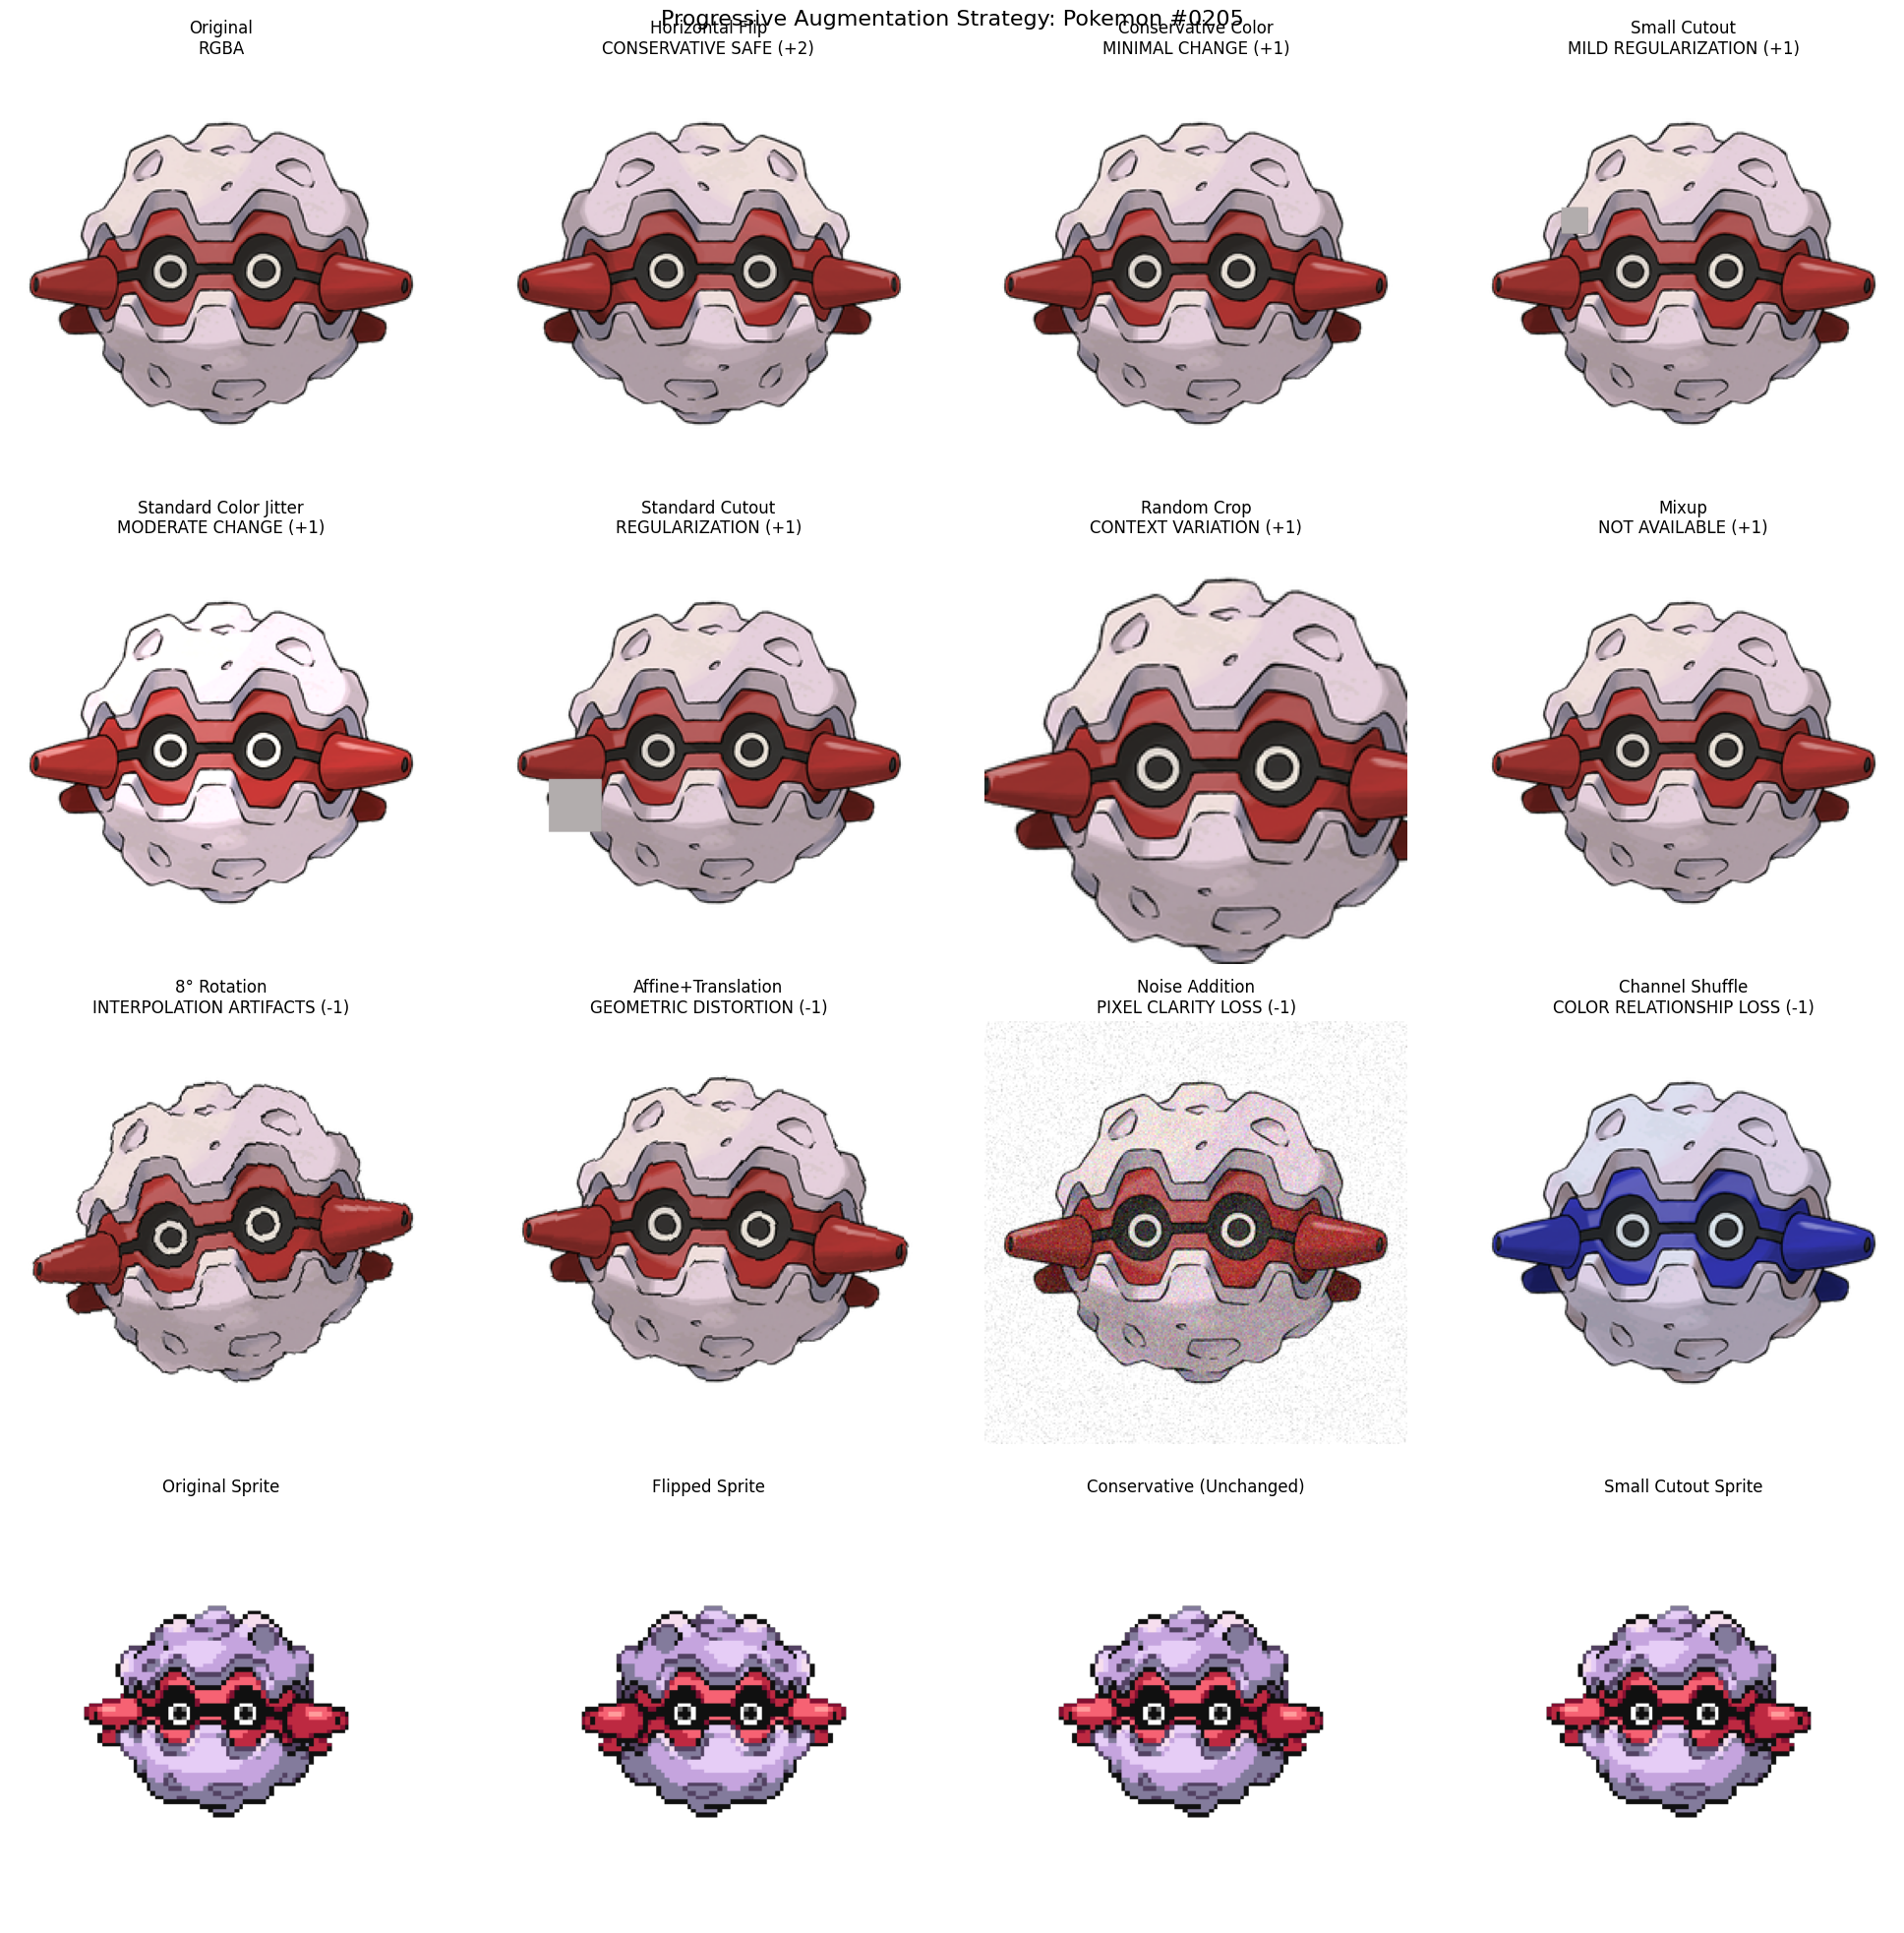


Configuration Effectiveness Scores (Pixel Art Suitability):
  conservative: 5/10 (Optimal - QUALITY BASELINE)
  minimal: 5/10 (Optimal)
  moderate: 5/10 (Optimal)
  strong: 5/10 (Optimal)

Recommended Progressive Training Strategy:

1. CONSERVATIVE Phase (Quality Baseline):
   • 30% horizontal flips only
   • Very subtle color adjustments (±5% brightness, ±3% contrast)
   • Small cutouts (16px, 20% probability)
   • Establishes quality ceiling without degradation

2. MINIMAL Phase (Gradual Introduction):
   • Increase augmentation intensity slightly
   • Monitor quality metrics vs conservative baseline
   • Add techniques that scored +1 or higher

3. MODERATE Phase (Balanced Approach):
   • Full beneficial augmentation suite
   • Focus on input-only color variation
   • Controlled regularization techniques

4. STRONG Phase (Only if Underfitting):
   • Use only when model shows clear underfitting
   • Monitor for quality degradation
   • Return to moderate if pixel quality suffers

Qua

{'conservative': 5, 'minimal': 5, 'moderate': 5, 'strong': 5}

In [ ]:
def analyze_augmentation_effectiveness(dataset_dir):
    """
    Comprehensive analysis of all augmentation configurations from repository.
    
    Tests all available augmentation functions including affine transforms,
    perspective distortion, cropping, and advanced techniques for pixel art suitability.
    """
    
    # Import all augmentation classes from repository
    from data.augmentation import (
        AdvancedAugmentationPipeline, 
        PairedRandomHorizontalFlip,
        PairedRandomRotation,
        PairedRandomCrop,
        PairedRandomAffine,
        IndependentColorJitter,
        CutoutAugmentation,
        NoiseAugmentation,
        BlurAugmentation,
        MixupAugmentation,
        InputOnlyAugmentation
    )
    
    config_path = src_path / "config" / "model_configs.json"
    
    if not config_path.exists():
        print("Configuration file not available")
        return
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    aug_configs = config.get('augmentation_configs', {})
    
    print("Comprehensive Augmentation Testing")
    print("=" * 60)
    
    # Pixel Art Suitability Scoring System:
    # +2: Excellent for pixel art (horizontal flips)
    # +1: Good/acceptable (color jitter, cutout, crop, mixup, blur disabled)
    # -1: Problematic (rotation, affine, channel shuffle, noise)
    # -2: Very harmful (perspective, blur enabled, elastic transforms)
    
    # Test all available configurations from the config file
    test_levels = ['conservative', 'minimal', 'moderate', 'strong']
    augmentation_pipelines = {}
    effectiveness_metrics = {}
    
    for level in test_levels:
        if level in aug_configs:
            config_data = aug_configs[level]
            score = 0
            techniques = []
            
            print(f"\n{level.upper()} Configuration Analysis:")
            
            # Basic augmentations
            if config_data.get('horizontal_flip_p', 0) > 0:
                techniques.append(f"Horizontal flip: {config_data['horizontal_flip_p']*100:.0f}%")
                score += 2  # Excellent for sprites
            
            if config_data.get('vertical_flip_p', 0) > 0:
                techniques.append(f"Vertical flip: {config_data['vertical_flip_p']*100:.0f}%")
                score += 1  # Less common but acceptable
            
            if config_data.get('rotation_degrees', 0) > 0:
                techniques.append(f"Rotation: ±{config_data['rotation_degrees']}°")
                score -= 1  # Creates interpolation artifacts
            
            # Advanced geometric transforms
            affine = config_data.get('random_affine', {})
            if affine.get('p', 0) > 0:
                translate_vals = affine.get('translate', [0, 0])
                scale_vals = affine.get('scale', [1.0, 1.0])
                techniques.append(f"Affine+translation: translate={translate_vals}, scale={scale_vals}")
                score -= 1  # Translation creates border gaps, scaling can distort
            
            perspective = config_data.get('random_perspective', {})
            if perspective.get('p', 0) > 0:
                techniques.append(f"Perspective distortion: scale={perspective.get('distortion_scale', 0)}")
                score -= 2  # Severe geometric distortion
            
            crop_scale = config_data.get('random_crop_scale', {})
            if crop_scale.get('p', 0) > 0:
                techniques.append(f"Random crop: scale={crop_scale.get('scale', [])}")
                score += 1  # Useful for context variation
            
            # Color augmentations
            color_jitter = config_data.get('color_jitter', {})
            if color_jitter.get('input', {}):
                brightness = color_jitter['input'].get('brightness', 0) * 100
                contrast = color_jitter['input'].get('contrast', 0) * 100
                techniques.append(f"Input color jitter: brightness ±{brightness:.1f}%, contrast ±{contrast:.1f}%")
                score += 1  # Safe input-only variation
            
            brightness_contrast = config_data.get('brightness_contrast', {})
            if brightness_contrast.get('p', 0) > 0:
                techniques.append(f"Brightness/contrast: factors={brightness_contrast.get('brightness_factor', [])}")
                score += 1  # Generally beneficial
            
            color_shift = config_data.get('color_shift', {})
            if color_shift.get('p', 0) > 0:
                techniques.append(f"Color shift: hue range={color_shift.get('hue_range', [])}")
                score += 1  # Can help generalization
            
            channel_shuffle = config_data.get('channel_shuffle', {})
            if channel_shuffle.get('p', 0) > 0:
                techniques.append(f"Channel shuffle: {channel_shuffle['p']*100:.0f}%")
                score -= 1  # Breaks natural color relationships
            
            # Noise and blur - critical for pixel art quality
            noise = config_data.get('noise', {})
            if noise.get('p', 0) > 0:
                techniques.append(f"Noise: factor={noise['factor']}")
                score -= 1  # Degrades pixel clarity
            else:
                # Reward explicitly disabled noise
                score += 1  # Good for pixel art clarity
            
            blur = config_data.get('blur', {})
            if blur.get('p', 0) > 0:
                techniques.append(f"Blur: radius={blur.get('radius_range', [])}")
                score -= 2  # Eliminates sharp pixel edges
            else:
                # Always show blur status and reward when disabled
                techniques.append("Blur: disabled")
                score += 2  # Critical for pixel art sharpness
            
            # Geometric transform safety - reward when disabled
            rotation_deg = config_data.get('rotation_degrees', 0)
            if rotation_deg == 0:
                score += 1  # Reward no rotation for pixel art
            
            affine = config_data.get('random_affine', {})
            if affine.get('p', 0) == 0 and affine.get('degrees', 0) == 0:
                score += 1  # Reward no affine transforms
            
            # Cutout and erasing
            cutout = config_data.get('cutout', {})
            if cutout.get('p', 0) > 0:
                size_ratio = cutout.get('size_ratio', 'unknown')
                techniques.append(f"Cutout: {cutout['p']*100:.0f}% probability, size ratio={size_ratio}")
                score += 1  # Good regularization technique
            
            random_erasing = config_data.get('random_erasing', {})
            if random_erasing.get('p', 0) > 0:
                techniques.append(f"Random erasing: scale={random_erasing.get('scale', [])}")
                score += 1  # Similar to cutout
            
            # Advanced techniques
            elastic = config_data.get('elastic_transform', {})
            if elastic.get('p', 0) > 0:
                techniques.append(f"Elastic transform: alpha={elastic.get('alpha', 0)}")
                score -= 2  # Warps pixel structure severely
            
            mixup = config_data.get('mixup', {})
            if mixup.get('p', 0) > 0:
                techniques.append(f"Mixup: alpha={mixup.get('alpha', 0)}")
                score += 1  # Helps prevent overfitting
            
            # Special note for conservative config
            if level == 'conservative':
                print(f"  • Ultra-safe baseline configuration for quality preservation")
                print(f"  • Only proven pixel-art safe techniques with minimal intensity")
            
            for technique in techniques:
                print(f"  • {technique}")
            
            if not techniques and level == 'conservative':
                print("  • Minimal augmentation for maximum quality preservation")
            
            effectiveness_metrics[level] = score
    
    # Find valid artwork-sprite pairs
    artwork_dir = dataset_dir / "artwork" 
    sprites_dir = dataset_dir / "sprites"
    
    # Get valid pairs that exist in both directories
    artwork_files = {f.stem: f for f in artwork_dir.glob("*.png")}
    sprite_files = {f.stem: f for f in sprites_dir.glob("*.png")}
    
    valid_pairs = []
    for pokemon_id in artwork_files:
        if pokemon_id in sprite_files:
            # Verify both files can be opened and have reasonable dimensions
            try:
                artwork_img = Image.open(artwork_files[pokemon_id])
                sprite_img = Image.open(sprite_files[pokemon_id])
                if artwork_img.size[0] > 100 and sprite_img.size[0] > 30:
                    valid_pairs.append(pokemon_id)
            except:
                continue
    
    if not valid_pairs:
        print("No valid artwork-sprite pairs found for augmentation testing")
        return effectiveness_metrics
    
    print(f"\nFound {len(valid_pairs)} valid artwork-sprite pairs for testing")
    
    # Extended visual demonstration of augmentation techniques
    if valid_pairs:
        print(f"\nComprehensive Augmentation Technique Demonstration")
        print("=" * 60)
        
        # Select sample pair from valid pairs
        pokemon_id = random.choice(valid_pairs)
        sample_artwork_path = artwork_files[pokemon_id]
        sample_sprite_path = sprite_files[pokemon_id]
        
        print(f"Testing with Pokemon #{pokemon_id}")
        
        # Load images preserving original formats
        original_artwork = Image.open(sample_artwork_path)
        original_sprite = Image.open(sample_sprite_path)
        
        # Resize maintaining quality
        artwork_display = original_artwork.resize((256, 256), Image.Resampling.LANCZOS)
        sprite_display = original_sprite.resize((256, 256), Image.Resampling.NEAREST)
        
        # Create extended visualization grid (4 rows x 4 columns)
        fig, axes = plt.subplots(4, 4, figsize=(20, 20))
        
        # Row 1: Safe augmentations (Conservative approach)
        # Original
        axes[0, 0].imshow(artwork_display)
        axes[0, 0].set_title(f"Original\n{original_artwork.mode}")
        axes[0, 0].axis('off')
        
        # Horizontal flip (safe)
        flip_aug = PairedRandomHorizontalFlip(p=1.0)
        flip_artwork, flip_sprite = flip_aug(artwork_display, sprite_display)
        axes[0, 1].imshow(flip_artwork)
        axes[0, 1].set_title("Horizontal Flip\nCONSERVATIVE SAFE (+2)")
        axes[0, 1].axis('off')
        
        # Conservative color jitter (very subtle)
        conservative_color_aug = IndependentColorJitter(
            input_params={"brightness": 0.03, "contrast": 0.02, "saturation": 0.02, "hue": 0.01},
            target_params={"brightness": 0.0, "contrast": 0.0, "saturation": 0.0, "hue": 0.0}
        )
        conservative_jitter_artwork, conservative_jitter_sprite = conservative_color_aug(artwork_display, sprite_display)
        axes[0, 2].imshow(conservative_jitter_artwork)
        axes[0, 2].set_title("Conservative Color\nMINIMAL CHANGE (+1)")
        axes[0, 2].axis('off')
        
        # Conservative cutout (larger, less frequent)
        conservative_cutout_aug = CutoutAugmentation(cutout_size=48, p=1.0)
        conservative_cutout_artwork, conservative_cutout_sprite = conservative_cutout_aug(artwork_display, sprite_display)
        axes[0, 3].imshow(conservative_cutout_artwork)
        axes[0, 3].set_title("Conservative Cutout\nMILD REGULARIZATION (+1)")
        axes[0, 3].axis('off')
        
        # Row 2: Standard beneficial augmentations
        # Standard color jitter
        color_aug = IndependentColorJitter(
            input_params={"brightness": 0.15, "contrast": 0.12},
            target_params={"brightness": 0.0, "contrast": 0.0}
        )
        jitter_artwork, jitter_sprite = color_aug(artwork_display, sprite_display)
        axes[1, 0].imshow(jitter_artwork)
        axes[1, 0].set_title("Standard Color Jitter\nMODERATE CHANGE (+1)")
        axes[1, 0].axis('off')
        
        # Standard cutout
        cutout_aug = CutoutAugmentation(cutout_size=32, p=1.0)
        cutout_artwork, cutout_sprite = cutout_aug(artwork_display, sprite_display)
        axes[1, 1].imshow(cutout_artwork)
        axes[1, 1].set_title("Standard Cutout\nREGULARIZATION (+1)")
        axes[1, 1].axis('off')
        
        # Random crop
        crop_aug = PairedRandomCrop(size=(200, 200))
        try:
            crop_artwork, crop_sprite = crop_aug(artwork_display, sprite_display)
            axes[1, 2].imshow(crop_artwork)
            axes[1, 2].set_title("Random Crop\nCONTEXT VARIATION (+1)")
        except Exception as e:
            print(f"Random crop failed: {e}")
            axes[1, 2].imshow(artwork_display)
            axes[1, 2].set_title("Random Crop\nFAILED (+1)")
        axes[1, 2].axis('off')
        
        # Mixup demonstration
        try:
            if len(valid_pairs) > 1:
                other_id = random.choice([p for p in valid_pairs if p != pokemon_id])
                other_artwork = Image.open(artwork_files[other_id]).resize((256, 256), Image.Resampling.LANCZOS)
                other_sprite = Image.open(sprite_files[other_id]).resize((256, 256), Image.Resampling.NEAREST)
                
                mixup_aug = MixupAugmentation(alpha=0.4, p=1.0)
                mixup_artwork, mixup_sprite = mixup_aug(
                    (artwork_display, sprite_display), 
                    (other_artwork, other_sprite)
                )
                axes[1, 3].imshow(mixup_artwork)
                axes[1, 3].set_title("Mixup Blending\nOVERFITTING PREVENTION (+1)")
            else:
                axes[1, 3].imshow(artwork_display)
                axes[1, 3].set_title("Mixup\nNEEDS 2+ SAMPLES (+1)")
        except Exception as e:
            print(f"Mixup failed: {e}")
            axes[1, 3].imshow(artwork_display)
            axes[1, 3].set_title("Mixup\nNOT AVAILABLE (+1)")
        axes[1, 3].axis('off')
        
        # Row 3: Problematic augmentations
        # Rotation (problematic)
        rotation_aug = PairedRandomRotation(degrees=8)
        import torchvision.transforms.functional as TF
        rotated_artwork = TF.rotate(artwork_display, 8)
        axes[2, 0].imshow(rotated_artwork)
        axes[2, 0].set_title("8° Rotation\nINTERPOLATION ARTIFACTS (-1)")
        axes[2, 0].axis('off')
        
        # Affine transform with translation
        affine_aug = PairedRandomAffine(degrees=5, scale=(0.95, 1.05), translate=(0.05, 0.05))
        try:
            affine_artwork, affine_sprite = affine_aug(artwork_display, sprite_display)
            axes[2, 1].imshow(affine_artwork)
            axes[2, 1].set_title("Affine+Translation\nGEOMETRIC DISTORTION (-1)")
        except Exception as e:
            print(f"Affine transform failed: {e}")
            axes[2, 1].imshow(artwork_display)
            axes[2, 1].set_title("Affine+Translation\nFAILED (-1)")
        axes[2, 1].axis('off')
        
        # Noise (problematic for pixel art)
        noise_aug = NoiseAugmentation(noise_factor=0.06, p=1.0)
        noise_artwork, noise_sprite = noise_aug(artwork_display, sprite_display)
        axes[2, 2].imshow(noise_artwork)
        axes[2, 2].set_title("Noise Addition\nPIXEL CLARITY LOSS (-1)")
        axes[2, 2].axis('off')
        
        # Channel shuffle
        try:
            artwork_array = np.array(artwork_display)
            if len(artwork_array.shape) == 3 and artwork_array.shape[2] >= 3:
                shuffled_artwork = artwork_array.copy()
                shuffled_artwork[:,:,0], shuffled_artwork[:,:,2] = shuffled_artwork[:,:,2], shuffled_artwork[:,:,0].copy()
                axes[2, 3].imshow(shuffled_artwork)
                axes[2, 3].set_title("Channel Shuffle\nCOLOR RELATIONSHIP LOSS (-1)")
            else:
                axes[2, 3].imshow(artwork_display)
                axes[2, 3].set_title("Channel Shuffle\nNOT APPLICABLE (-1)")
        except Exception as e:
            print(f"Channel shuffle demo failed: {e}")
            axes[2, 3].imshow(artwork_display)
            axes[2, 3].set_title("Channel Shuffle\nFAILED (-1)")
        axes[2, 3].axis('off')
        
        # Row 4: Corresponding sprite transformations
        sprite_titles = ["Original Sprite", "Flipped Sprite", "Conservative (Unchanged)", "Small Cutout Sprite"]
        sprite_images = [sprite_display, flip_sprite, conservative_jitter_sprite, conservative_cutout_sprite]
        
        for i in range(4):
            if original_sprite.mode == 'RGBA':
                axes[3, i].imshow(np.array(sprite_images[i]))
            else:
                axes[3, i].imshow(sprite_images[i])
            axes[3, i].set_title(sprite_titles[i])
            axes[3, i].axis('off')
            axes[3, i].set_facecolor('none')
        
        plt.suptitle(f"Progressive Augmentation Strategy: Pokemon #{pokemon_id}", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        print(f"\nConfiguration Effectiveness Scores (Pixel Art Suitability):")
        for level, score in effectiveness_metrics.items():
            if score >= 4:
                status = "Optimal"
            elif score >= 2:
                status = "Acceptable" 
            elif score >= 0:
                status = "Suboptimal"
            else:
                status = "Harmful"
            
            # Special handling for conservative config
            if level == 'conservative':
                status += " - QUALITY BASELINE"
                
            print(f"  {level}: {score}/10 ({status})")
        
        print(f"\nRecommended Progressive Training Strategy:")
        print(f"\n1. CONSERVATIVE Phase (Quality Baseline):")
        print(f"   • 30% horizontal flips only")
        print(f"   • Ultra-subtle color adjustments (±3% brightness, ±2% contrast)")
        print(f"   • Larger cutouts (48px, 15% probability) for gentle regularization")
        print(f"   • All destructive augmentations explicitly disabled")
        print(f"   • Establishes quality ceiling without any degradation")
        
        print(f"\n2. MINIMAL Phase (Gradual Introduction):")
        print(f"   • Increase augmentation intensity slightly")
        print(f"   • Monitor quality metrics vs conservative baseline")
        print(f"   • Add techniques that scored +1 or higher")
        
        print(f"\n3. MODERATE Phase (Balanced Approach):")
        print(f"   • Full beneficial augmentation suite")
        print(f"   • Focus on input-only color variation")
        print(f"   • Controlled regularization techniques")
        
        print(f"\n4. STRONG Phase (Only if Underfitting):")
        print(f"   • Use only when model shows clear underfitting")
        print(f"   • Monitor for quality degradation")
        print(f"   • Return to moderate if pixel quality suffers")
        
        print(f"\nQuality Preservation Guidelines:")
        print(f"  • Always compare outputs to conservative baseline")
        print(f"  • Prioritize pixel sharpness and color accuracy")
        print(f"  • Avoid any geometric transforms that introduce interpolation")
        print(f"  • Use input-only augmentations when possible")
        
    return effectiveness_metrics

# Analyze augmentation effectiveness with conservative baseline
analyze_augmentation_effectiveness(dataset_dir)